In [15]:
import random

def generate_data(num_entries, num_rows, filename):
    # Open the file for writing
    with open(filename, 'w') as file:
        # Generate each row
        for i in range(num_rows):
            # Generate each entry in the row as a list of 3 integers following a simple pattern
            row = [
                f"[{random.randint(1, 69)}, {random.randint(5, 80)}, {random.randint(1, 67)}]"
                for _ in range(num_entries)
            ]
            # Join all entries into a single string with commas and write to file
            formatted_row = ', '.join(row)
            file.write(f"\"{formatted_row}\"\n")

# Example usage:
generate_data(200, 500, 'fake_data.csv')

In [16]:
import numpy as np
import pandas as pd
import ast

# Load and parse the CSV data
def load_and_parse_data(file_path):
    data = pd.read_csv(file_path, header=None)
    sequences = []
    for index, row in data.iterrows():
        # Convert the row from string representation to list of lists of integers
        sequence = ast.literal_eval(row[0])
        sequences.append(sequence)
    return np.array(sequences)

# Split sequences into input and target
def split_sequences(sequences):
    inputs = []
    targets = []
    for seq in sequences:
        mid = len(seq) // 2
        inputs.append(seq[:mid])
        targets.append(seq[mid:])
    return np.array(inputs), np.array(targets)

# Load and preprocess the data
file_path = 'fake_data.csv'  # replace with your file path
sequences = load_and_parse_data(file_path)
inputs, targets = split_sequences(sequences)

print(inputs)
print(targets)



[[[   9    0    5]
  [   1    0    2]
  [   2    0    4]
  ...
  [   3    0    4]
  [   5    0    4]
  [   9    0    5]]

 [[   5    6    3]
  [   9    7    4]
  [  10    7    2]
  ...
  [   7    6    4]
  [   4    5    6]
  [  11    5    1]]

 [[   7   14    6]
  [  10   10    1]
  [  12   10    4]
  ...
  [   4   16    6]
  [   8   12    5]
  [  11   16    2]]

 ...

 [[ 501 3479   33]
  [ 501 3479  312]
  [ 505 2982  215]
  ...
  [ 501 2982    3]
  [ 500 2485  350]
  [ 505 2982  487]]

 [[ 503 2490   15]
  [ 506 3486  502]
  [ 501 2490   19]
  ...
  [ 499 3984  119]
  [ 506 3486  377]
  [ 508 3486  197]]

 [[ 509 2495  184]
  [ 500 2495  255]
  [ 509 3493  111]
  ...
  [ 503 3992  260]
  [ 500 3493  119]
  [ 509 3992  492]]]
[[[   7    0    3]
  [   9    0    5]
  [  10    0    1]
  ...
  [   3    0    1]
  [   4    0    2]
  [   2    0    4]]

 [[   5    6    2]
  [   5    7    6]
  [  10    6    2]
  ...
  [   4    5    3]
  [   2    7    3]
  [   5    8    2]]

 [[  12   16    6]

In [17]:
from sklearn.model_selection import train_test_split

# Splitting the Data
input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

In [27]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from keras.regularizers import l2

# Defining constants we are going to use
n_input = 100  # Adjusted from 1250 to match the actual sequence length
n_output = 100  # Assuming output sequence length is the same as input
n_features = 3

# Define the model
model = Sequential()

# Encoder part
model.add(LSTM(150, activation='tanh', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.2))

# Another LSTM layer
model.add(LSTM(100, activation='tanh', return_sequences=False))

# RepeatVector is used as a bridge between the encoder and decoder parts
model.add(RepeatVector(n_output))


# Decoder part
model.add(LSTM(150, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh', return_sequences=True))

# Densely connected output layer
model.add(TimeDistributed(Dense(n_features)))

# Compiling the model
optimizer = Adam(clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')

In [28]:
model.fit(input_train, target_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
13/13 [==============================] - 13s 459ms/step - loss: 1209001.7500
Epoch 2/10
13/13 [==============================] - 6s 433ms/step - loss: 1198935.8750
Epoch 3/10
13/13 [==============================] - 6s 447ms/step - loss: 1195414.5000
Epoch 4/10
13/13 [==============================] - 6s 446ms/step - loss: 1192746.7500
Epoch 5/10
13/13 [==============================] - 6s 455ms/step - loss: 1190176.0000
Epoch 6/10
13/13 [==============================] - 6s 465ms/step - loss: 1187569.3750
Epoch 7/10
13/13 [==============================] - 6s 438ms/step - loss: 1185083.6250
Epoch 8/10
13/13 [==============================] - 6s 444ms/step - loss: 1182555.2500
Epoch 9/10
13/13 [==============================] - 6s 435ms/step - loss: 1180024.0000
Epoch 10/10
13/13 [==============================] - 6s 447ms/step - loss: 1177499.2500


In [29]:
loss = model.evaluate(input_test, target_test, verbose=0)
print('Model loss:', loss)

Model loss: 1318694.375


1/1 [==============================] - 1s 1s/step


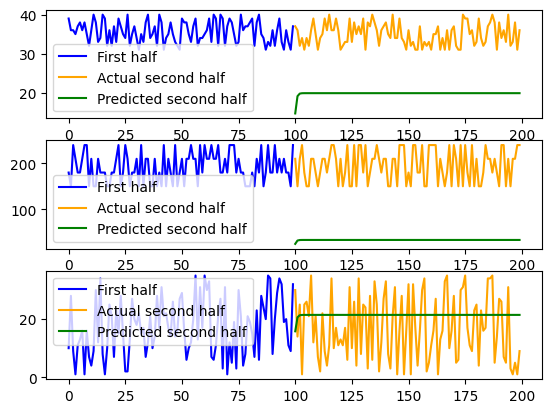

In [30]:
import matplotlib.pyplot as plt
import random

# pick a random index from the test dataset
idx = random.randint(0, len(input_test) - 1)

# get the corresponding sequences
input_seq = input_test[idx]
target_seq = target_test[idx]

# reshape the input sequence and make a prediction
predicted_seq = model.predict(input_seq.reshape(1, -1, 3))[0]

# create three subplots, one for each variable
fig, axs = plt.subplots(3)

# use different colors for the first half, actual second half and predicted second half
colors = ['blue', 'orange', 'green']

for i in range(3):
    # plot the first half of the sequence
    axs[i].plot(range(0, n_input), input_seq[:, i], color=colors[0], label='First half')
    # plot the second half of the sequence
    axs[i].plot(range(n_input, 2*n_input), target_seq[:, i], color=colors[1], label='Actual second half')
    # plot the model's prediction for the second half of the sequence
    axs[i].plot(range(n_input, 2*n_input), predicted_seq[:, i], color=colors[2], label='Predicted second half')
    axs[i].legend()

plt.show()

1/1 [==============================] - 0s 72ms/step


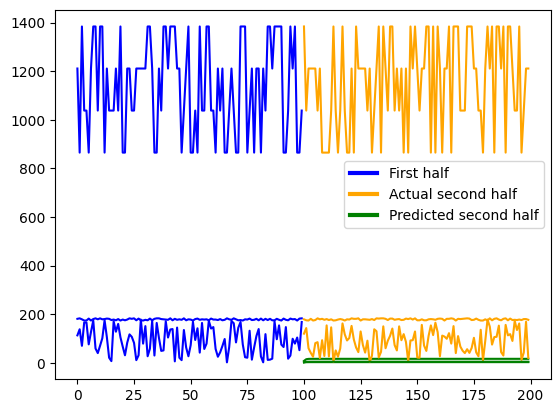

In [25]:
from matplotlib.lines import Line2D

# Assuming input_test and target_test are correctly shaped as (num_samples, n_input, n_features)
# Pick a random index from the test dataset
idx = random.randint(0, len(input_test) - 1)

# Get the corresponding sequences
input_seq = input_test[idx]
target_seq = target_test[idx]

# Reshape the input sequence for prediction if necessary
if input_seq.ndim < 3:
    input_seq = input_seq.reshape(1, n_input, n_features)

# Make a prediction
predicted_seq = model.predict(input_seq)[0]

# Create a plot
fig, ax = plt.subplots()

# Use different colors for the first half, actual second half, and predicted second half
colors = ['blue', 'orange', 'green']

# Plot the first half of the sequence, the second half of the sequence, and the prediction
for i in range(n_features):
    ax.plot(range(0, n_input), input_seq[0, :, i], color=colors[0])
    ax.plot(range(n_input, 2*n_input), target_seq[:, i], color=colors[1])
    ax.plot(range(n_input, 2*n_input), predicted_seq[:, i], color=colors[2])

# Set up legend
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['First half', 'Actual second half', 'Predicted second half']
ax.legend(lines, labels)

plt.show()